In [1]:
# coding=utf-8
from __future__ import absolute_import, print_function
import argparse
from Model2Feature import Model2Feature
from utils import AverageMeter
from evaluations import Recall_at_ks, pairwise_similarity
from utils.serialization import load_checkpoint
import torch
import ast
import time
from models.SimpleNet import SimpleNet


def main(args):
    batch_time = AverageMeter()
    end = time.time()

    checkpoint = load_checkpoint(args.resume)               #loaded
    print('pool_features:',args.pool_feature)
    epoch = checkpoint['epoch']

    gallery_feature, gallery_labels, query_feature, query_labels = \
    Model2Feature(data=args.data, root=args.data_root, net=args.net, checkpoint=checkpoint
    , batch_size=args.batch_size, nThreads=args.nThreads, pool_feature=args.pool_feature)    #output


    sim_mat = pairwise_similarity(query_feature, gallery_feature)    #成对相似性
    if args.gallery_eq_query is True:
        sim_mat = sim_mat - torch.eye(sim_mat.size(0))

    #print('labels',query_labels)
    print('feature:',gallery_feature)


    recall_ks = Recall_at_ks(sim_mat, query_ids=query_labels, gallery_ids=gallery_labels, data=args.data)

    result = '  '.join(['%.4f' % k for k in recall_ks])   #   result=recall_ks
    print('Epoch-%d' % epoch, result)
    batch_time.update(time.time() - end)

    print('Epoch-%d\t' % epoch,
          'Time {batch_time.avg:.3f}\t'.format
          ( batch_time=batch_time ))
    return gallery_feature


if  __name__ == '__main__':

    parser = argparse.ArgumentParser(description='PyTorch Testing')

    parser.add_argument('--data', type=str, default='sign')
    parser.add_argument('--data_root', type=str, default="F:/Python深度学习/python_Project/IoT/DataSet")
    parser.add_argument('--gallery_eq_query', '-g_eq_q', type=ast.literal_eval, default=True,help='Is gallery identical with query')

    parser.add_argument('--net', type=str, default='Simple-Net')
    parser.add_argument('--resume', '-r', type=str, default="F:/Python深度学习/python_Project/IoT/models/ckp_ep30.pth.tar", metavar='PATH')  #checkpoint的绝对路径

    #parser.add_argument('--dim', '-d', type=int, default=512,help='Dimension of Embedding Feather')
    #parser.add_argument('--width', type=int, default=224,help='width of input image')
    parser.add_argument('--set_name', default="test",  help='training set or testing set')
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--nThreads', '-j', default=0, type=int, metavar='N',help='number of data loading threads (default: 2)')
    parser.add_argument('--pool_feature', type=ast.literal_eval, default=False, required=False,help='if True extract feature from the last pool layer')
    feature = main(parser.parse_args(args=[]))

=> Loaded checkpoint 'F:/Python深度学习/python_Project/IoT/models/ckp_ep30.pth.tar'
pool_features: False
using else
Extract Features: [46/46]	Time 0.010 (0.010)	Data 24.151 (24.151)	
feature: tensor([[-0.0301, -0.0177, -0.1412,  ..., -0.5627,  0.2589,  0.2064],
        [-0.2405,  0.3419,  0.2718,  ..., -0.2958,  0.1459,  0.2882],
        [-0.2047,  0.0995,  0.2092,  ..., -0.2898,  0.3804,  0.3945],
        ...,
        [ 0.4326,  0.1515, -0.0040,  ..., -0.1038, -0.3673,  0.0624],
        [-0.2830,  0.5115,  0.1066,  ..., -0.4587,  0.1013,  0.1648],
        [-0.1494, -0.1900,  0.2732,  ...,  0.0239,  0.1537,  0.1678]])
Epoch-30 0.5584  0.7310  0.8047  0.8478  0.8852  0.9049
Epoch-30	 Time 175.814	


In [15]:
    from PIL import Image
    import matplotlib.pyplot as plt
    from torchvision import transforms
    import torchvision
    import numpy as np
 
    similarity = torch.mm(feature, feature.t())
    similarity.size()

torch.Size([2944, 2944])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


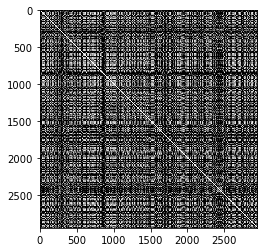

In [16]:
    img=torchvision.utils.make_grid(similarity).numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()